# Using manipulated data

In [31]:
%matplotlib inline

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tick
from tick.base import TimeFunction
from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process
from tick.hawkes import HawkesExpKern
from tick.plot import plot_hawkes_kernel_norms
import os
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error

In [33]:
# Set global font properties
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman', 'Palatino', 'Georgia']
plt.rcParams['font.size'] = 14

In [34]:
def simulate_markov_chain(P, num_steps, start_state=0, sc = 0.01):
    """
    Simulate a Markov chain given a transition matrix P.
    
    Parameters:
    - P: Transition matrix (2D numpy array)
    - num_steps: Number of steps to simulate
    - start_state: Initial state (default is 0)
    
    Returns:
    - List of states over time
    """
    #np.random.seed(0)
    # Ensure the matrix is a numpy array
    P = np.array(P)
    
    # Initialize the current state and the list to store the sequence of states
    current_state = start_state
    states = [current_state]
    Values = np.array([-sc, sc])
    # Simulate the Markov chain
    for _ in range(num_steps):
        next_state = np.random.choice(len(P), p=P[current_state])
        states.append(next_state)
        current_state = next_state
    val = [Values[s] for s in states]    
    return val

In [100]:
def get_windows(df, a_star, lam, mu_hat, sigma):
    df_ = df
    df_ = df.set_index('datetime')
    windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
    std_values = {}
    std_values_theory = {}
    for window in windows:
        window = str(window) + 'S'
        mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
        jump = df_['mid_price'].resample(window).size() * a_star
        p_result = mid_price - jump

        std_value = p_result.dropna().std()
        std_values[window] = std_value
        n = float(window.replace('S',''))
        std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()

    # Plotting the results
    #std_values, std_values_theory
    return std_value, std_values_theory

def mycurvefit(std_values, std_values_theory):
    x = [int(key[:-1]) for key in std_values.keys()]
    y = list(std_values.values())

    def func(x, a, b):
        return a * np.sqrt(x) + b
    params, covariance = curve_fit(func, x, y)
    a, b = params
    y_pred = func(x, a, b)
    y_true = list(std_values_theory.values())
    #y_signal = y
    return  y_pred, y_true, a, b

## Read data

from 2020 paper we have <br/>

|     |  λ | α   |  β | Emp. E[N([0, 1])] |pdd |puu |σ| a∗|
| --- | --- | --- | --- | --- |--- |--- |--- |--- |
| AMZN | 0.6443 | 653.7524 | 1556.1702 | 1.1110|  0.4635| 0.4576| 0.0046 |−2.7373 × 10−5|

In this case, −δ will be state one, and δ with be state two.


standard parameter from the above table are not stable

In [35]:
def compute_v(b, g, P):
    """
    Compute v based on the given formula.
    
    Parameters:
    - i: the current state
    - b: a function or dictionary that gives b(i) for each i
    - g: a function or dictionary that gives g(i) for each i
    - P: a 2D array or dictionary of dictionaries that gives P(i, j) for each pair i, j    
    Returns:
    - v
    """
    v = np.zeros(b.shape)
    S = np.array([i for i in range(len(b))])
    for i in range(len(b)):
        term1 = b[i]**2
        term2 = np.sum([(g[j] - g[i])**2 * P[i][j] for j in S])
        term3 = -2 * b[i] * np.sum([(g[j] - g[i]) * P[i][j] for j in S])
        v[i] = term1 + term2 + term3
    
    return v

In [68]:
def simulate_all(seed):
    stat = {}
    adjacency = np.array([[0.64149858]]) #alpha
    decay = 1205.6028014007004 # beta
    baselines = np.array([0.38069134]) #lambda
    stat["alpha"] = adjacency[0] * decay
    stat["beta"] =  decay
    stat["lam"] = baselines[0]
    
    
    hw = SimuHawkesExpKernels(adjacency, decay, baseline=baselines, seed=seed,verbose=False)
    hw.track_intensity(0.1)
    hw.end_time = 21470.779758
    hw.simulate()

    ts = hw.timestamps[0] #ts
    # Convert ts_rescaled to datetime
    start_time = pd.Timestamp('2012-06-21 00:00:00') 
    datetime_array = start_time + pd.to_timedelta(ts, unit='s')

    # Create a DataFrame
    df = pd.DataFrame({
        'datetime': datetime_array,
        'time': ts
    })

    pdd = 0.4635
    puu = 0.4576
    P = [[pdd, 1-pdd],
        [1-puu, puu]]

    num_steps = len(ts)
    start_state = 0

    df['mid_diff'] = np.array(simulate_markov_chain(P, num_steps, start_state))[1:]
    df['mid_price'] = df['mid_diff'].cumsum()
    df = df[['time', 'datetime', 'mid_price', 'mid_diff']]
    df['state'] = np.where(df['mid_diff'] >= 0, 1, 0)
    df['state'] = df['state'].astype('int')


    # Assuming transition_probs is your transition matrix
    transition_probs = P
    P = np.array(P)
    # Create a matrix where each row is P - I
    matrix = P.T - np.eye(P.shape[0])

    # Replace the last row with ones to account for the probability constraint
    matrix[-1, :] = 1

    # Create the target vector, with a 1 at the end for the probability constraint
    target = np.zeros(P.shape[0])
    target[-1] = 1

    # Solve the linear system
    stationary_probs = np.linalg.solve(matrix, target)

    best_hawkes = hw
    best_decay = decay

    n_state_tot = 2
    lam = best_hawkes.baseline
    alpha = best_hawkes.adjacency
    beta = best_decay
    mu_hat = alpha# (alpha*beta)/beta
    a = np.array([-0.01, 0.01])#a_negative + a_positive)
    a_star = np.dot(stationary_probs, a)
    b = a - a_star
    # # compute g 
    P = transition_probs
    Pi = np.tile(stationary_probs, (len(stationary_probs), 1))
    # Identity matrix
    I = np.eye(n_state_tot)
    # Compute the inverse of P + Pi - I
    g = np.linalg.inv(P + Pi - I)@ b
    v =compute_v(b, g, P) 
    sigma_2 = np.dot(stationary_probs, v)
    sigma = np.sqrt(sigma_2)
    sigma_star = sigma * np.sqrt(lam / (1 - mu_hat))
    
    stat["sigma"] = sigma
    stat["a_star"] = a_star
    stat["mu_hat"] = mu_hat
    stat["pi"] = stationary_probs
    stat["p"] = P
    df_ = df
    df_ = df.set_index('datetime')
    windows = range(360, 1200, 20)  # This will create a list [10, 20, 30, ..., 800]
    std_values = {}
    std_values_theory = {}
    for window in windows:
        window = str(window) + 'S'
        mid_price =  df_['mid_price'].resample(window).apply(lambda x: x[-1] - x[0])
        jump = df_['mid_price'].resample(window).size() * a_star
        p_result = mid_price - jump

        std_value = p_result.dropna().std()
        std_values[window] = std_value
        n = float(window.replace('S',''))
        std_values_theory[window] = (np.sqrt(lam/(1 - mu_hat))*sigma*np.sqrt(n)).item()
    return df, std_values, std_values_theory, stat, hw
    # Plotting the results
    #std_values, std_values_theory


In [69]:
df, _, _, stat, hw = simulate_all(int(12))

In [58]:
"& ".join(map(str, [stat["lam"], stat["alpha"][0], stat["beta"]]))

'0.38069134& 773.3924851425713& 1205.6028014007004'

In [66]:
"& ".join(map(str, [stat["p"][-1][-1], stat["p"][0][0], stat["sigma"], stat["mu_hat"][0][0], stat["a_star"]]))

'0.4576& 0.4635& 0.009239666602883547& 0.64149858& -5.468532764853179e-05'

In [52]:
stat

{'alpha': array([773.39248514]),
 'beta': 1205.6028014007004,
 'lam': 0.38069134,
 'sigma': 0.009239666602883547,
 'a_star': -5.468532764853179e-05,
 'mu_hat': array([[0.64149858]]),
 'pi': array([0.50273427, 0.49726573]),
 'p': [[0.4635, 0.5365], [0.5424, 0.4576]]}

In [76]:
hw.intensity_tracked_times

array([0.00000e+00, 1.00000e-01, 2.00000e-01, ..., 2.14705e+04,
       2.14706e+04, 2.14707e+04])

In [75]:
hw.tracked_intensity[0].shape
hw.intensity_tracked_times.shape


(238303,)

In [84]:
hw.intensity_tracked_times[-1]/3600

5.964083333324459

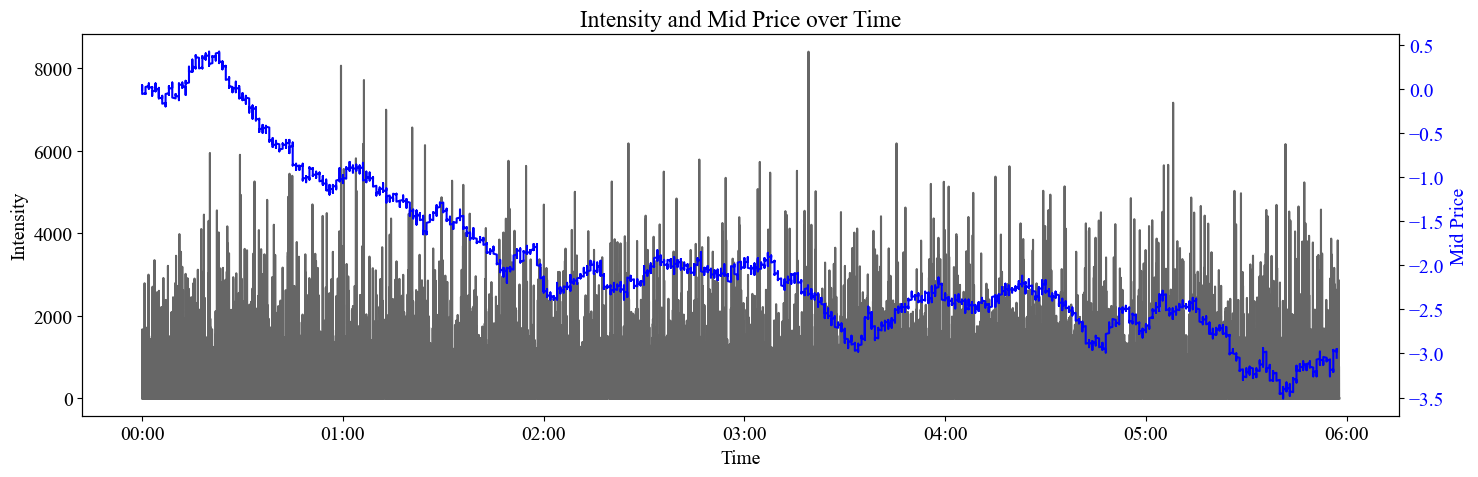

In [95]:
import matplotlib.pyplot as plt

# Extracting the data
x_data = hw.intensity_tracked_times
y_data = hw.tracked_intensity[0]

# Convert seconds to hours and minutes for plotting
time_as_float = x_data / 3600# // 3600 + (x_data % 3600) / 60

# Plotting
fig, ax1 = plt.subplots(figsize=(15,5))

# Plot intensity on the left y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Intensity', color='k')
ax1.plot(time_as_float, y_data, color='k', alpha = 0.6,  label='Intensity')
ax1.tick_params(axis='y', labelcolor='k')

# Create a second y-axis for the mid_price
ax2 = ax1.twinx()
ax2.set_ylabel('Mid Price', color='b')
# Use the 'datetime' column for the x-axis values
xx_time = df['datetime'].dt.hour + df['datetime'].dt.minute / 60
ax2.plot(xx_time, df['mid_price'], color='b', label='Mid Price')
ax2.tick_params(axis='y', labelcolor='b')

# Format x-axis to show only hours and minutes
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:02d}:{:02d}'.format(int(x), int((x*60) % 60))))

#start_hour = 5
#end_hour = 8
#ax1.set_xlim(start_hour, end_hour) 

plt.title('Intensity and Mid Price over Time')
plt.tight_layout()
#plt.savefig("intensity_and_price.png", dpi=300, bbox_inches='tight')
plt.show()


In [98]:
#from tick.plot import plot_point_process

In [99]:
#plot_point_process(hw, plot_intensity=True)

In [37]:
sd = np.random.choice(20000, 600)

In [38]:
stdv = []
stdt = []
for s in sd:
    _, ss, stt, _, _ = simulate_all(int(s))
    stdv.append(ss)
    stdt.append(stt)

In [39]:
def get_avg(data):
    sums = {key: 0 for key in data[0].keys()}
    for d in data:
        for key, value in d.items():
            sums[key] += value
    averages = {key: value / len(data) for key, value in sums.items()}
    return averages

In [40]:
std_values = get_avg(stdv)
std_values_theory = get_avg(stdt)

In [101]:
y_pred, y_true, a, b = mycurvefit(std_values, std_values_theory)
rmse = mean_squared_error(y_true, y_pred, squared=False)
rmse

0.003374175424326296

In [102]:
"& ".join(map(str, [a, b, rmse]))

'0.00915658561719779& 0.007037441264626853& 0.003374175424326296'

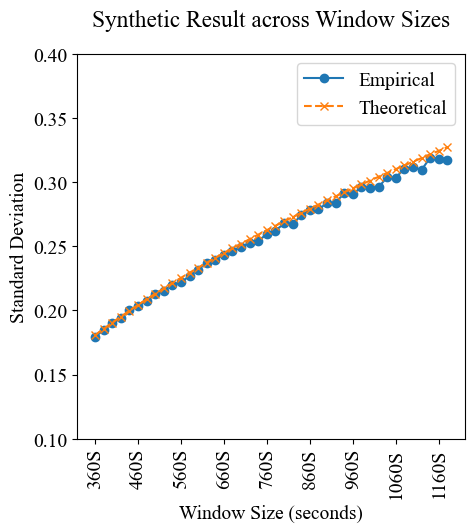

In [ ]:
# 10 Plotting the results
plt.figure(figsize=(5, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Synthetic Result across Window Sizes', y= 1.05)
plt.legend()
n = 5
keys = list(std_values.keys())
plt.xticks(keys[::n], keys[::n], rotation=90)
plt.ylim([.1, 0.4])
#plt.grid(True)
plt.savefig("./pics/synth_std_ns_1.png", dpi=300, bbox_inches='tight')
plt.show()

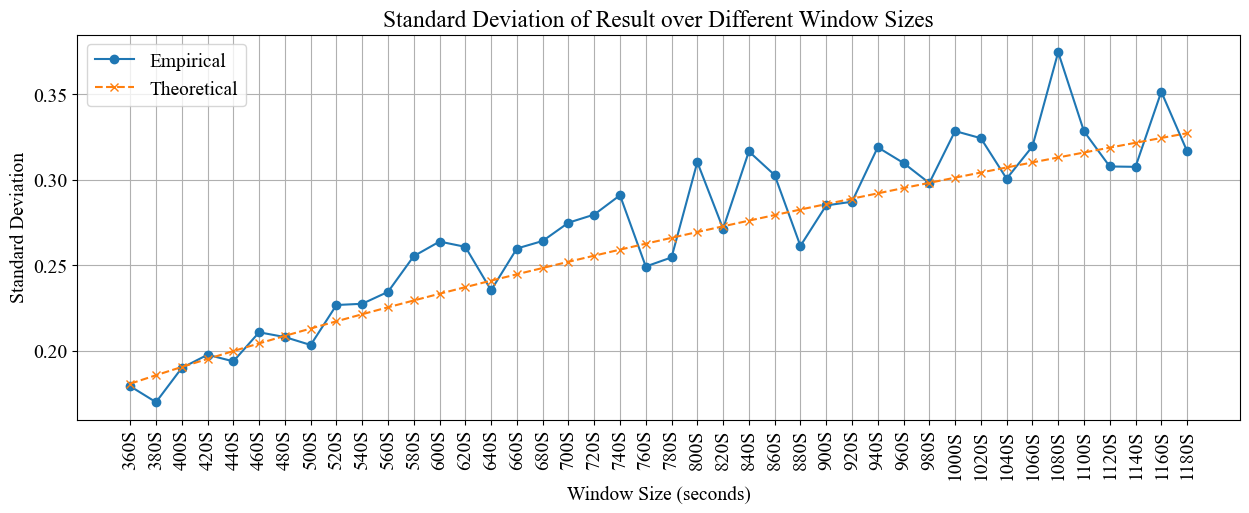

In [26]:
# 2 Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

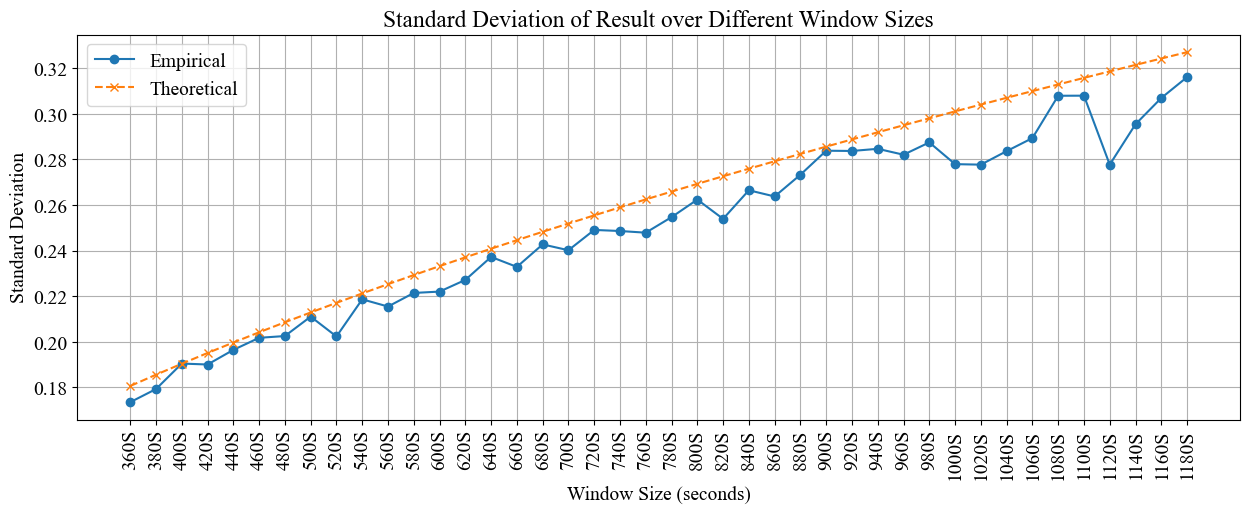

In [22]:
# 20 Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

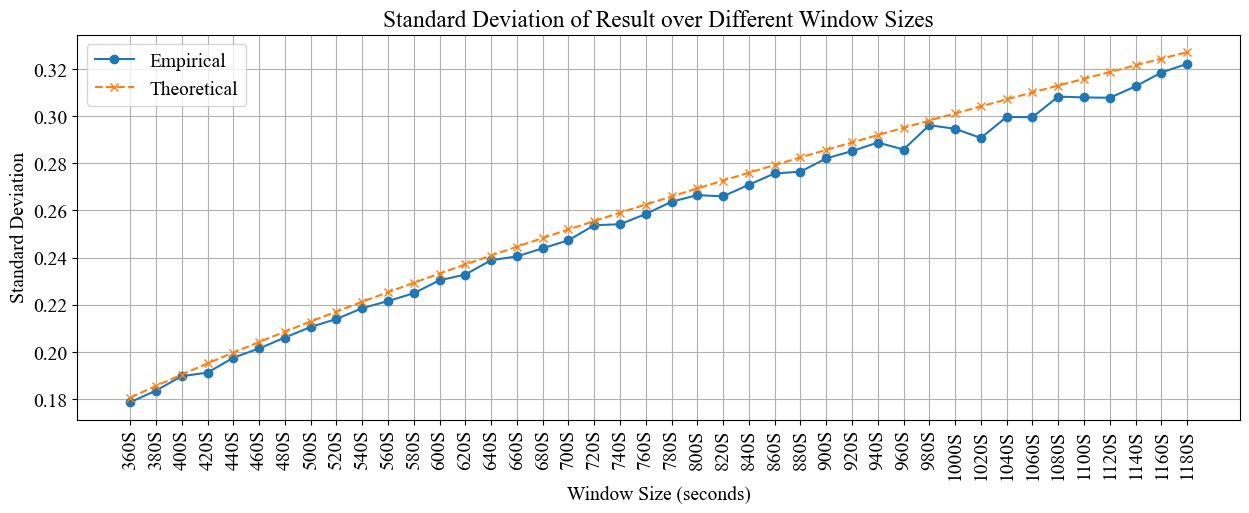

In [18]:
# 200 Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

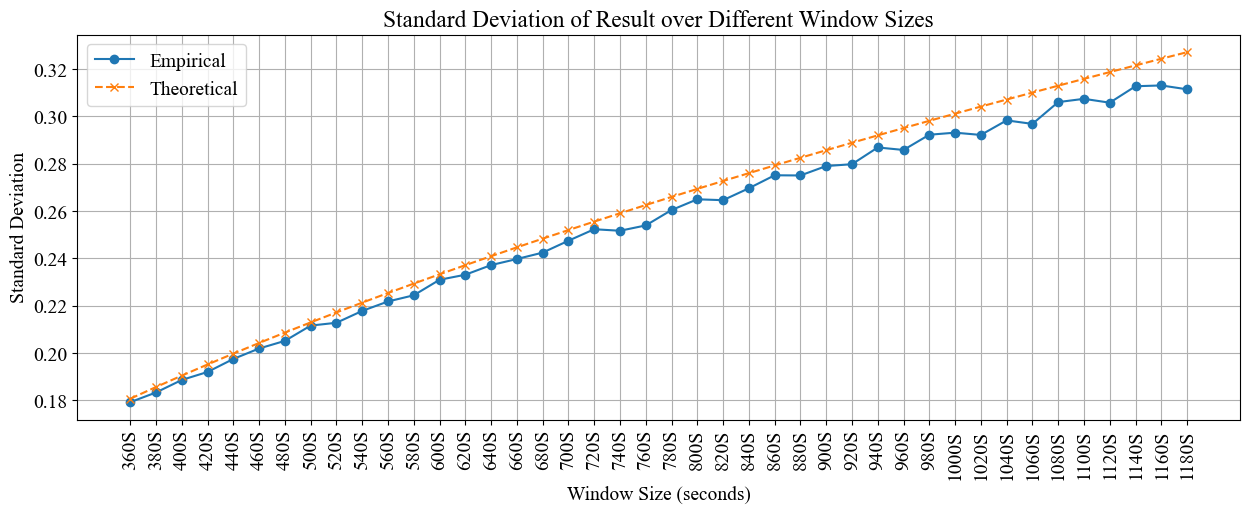

In [13]:
# 400 Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

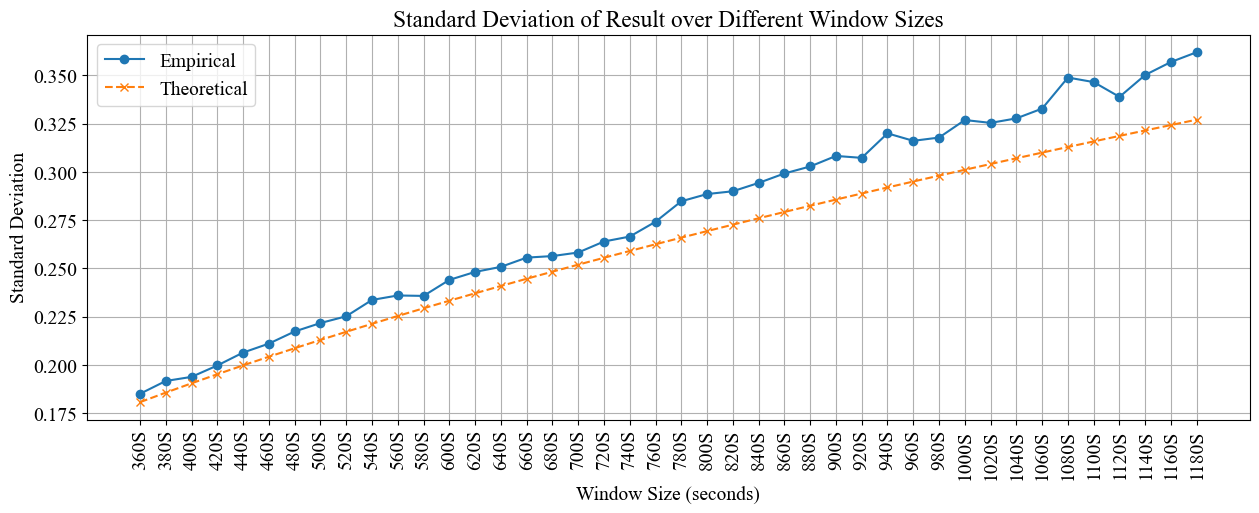

In [52]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

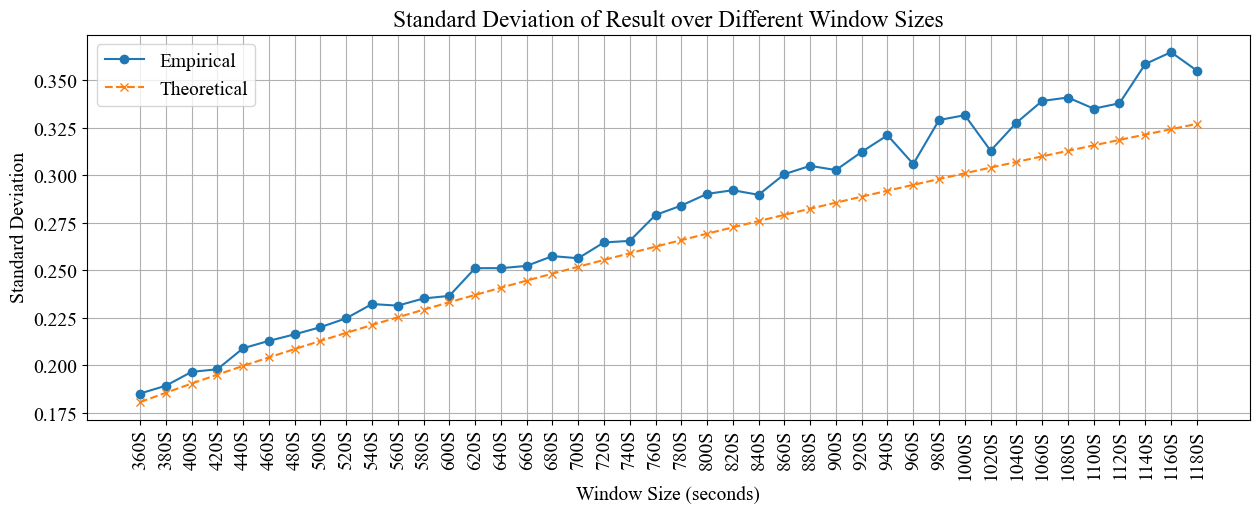

In [42]:
# Plotting the results
plt.figure(figsize=(15, 5))
plt.plot(list(std_values.keys()), list(std_values.values()), marker='o', label='Empirical')
plt.plot(list(std_values_theory.keys()), list(std_values_theory.values()), marker='x', linestyle='--', label='Theoretical')
plt.xlabel('Window Size (seconds)')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Result over Different Window Sizes')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

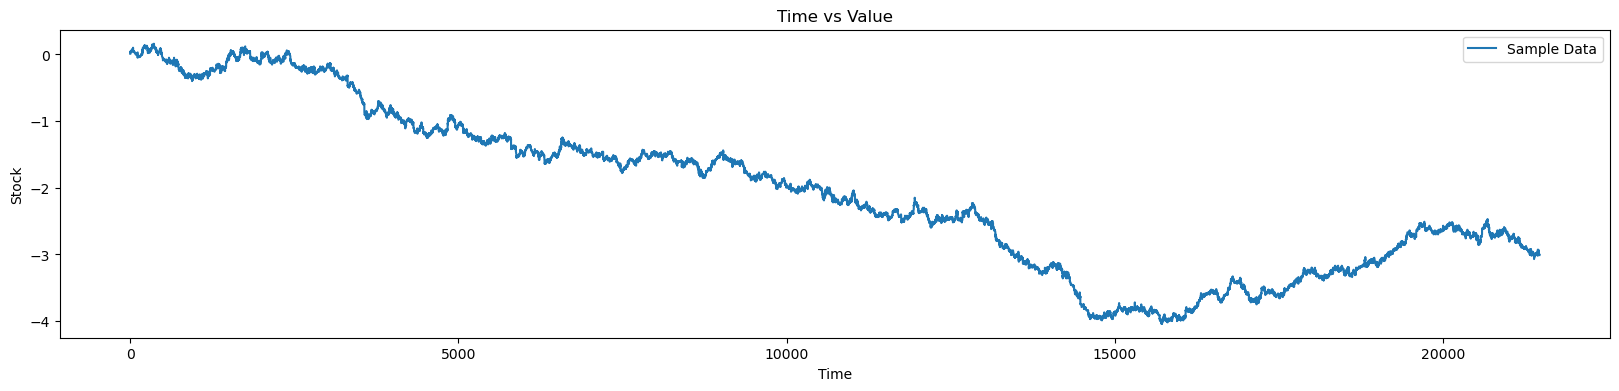

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(df['time'], df['mid_price'], "-", label='Sample Data')
# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Stock')
ax.set_title('Time vs Value')
ax.legend()

## Transition probability

In [10]:
# n_state_tot = 2
# # Initialize transition matrix
# transition_matrix = np.zeros((n_state_tot, n_state_tot))

# # Compute transitions
# for i in range(len(df['state']) - 1):
#     current_state = df['state'].iloc[i]
#     next_state = df['state'].iloc[i + 1]
#     transition_matrix[current_state][next_state] += 1

# # Normalize to get probabilities
# transition_probs = transition_matrix / transition_matrix.sum(axis=1)[:, None]
# print(transition_probs)

In [11]:
print(stationary_probs)
print("================")
print(stationary_probs @ P)
print("================")
print(np.sum(stationary_probs))

[0.50273427 0.49726573]
[0.50273427 0.49726573]
1.0


## Hawkes process

In [14]:
print(f'n = {best_hawkes.n_nodes}',
      f'mu = {best_hawkes.baseline}', 
      f'alpha = {best_hawkes.adjacency}', '\n'
      f'beta = {best_decay}, alpha_p = {best_hawkes.adjacency * best_decay}')

n = 1 mu = [0.38069134] alpha = [[0.64149858]] 
beta = 1205.6028014007004, alpha_p = [[773.39248514]]


In [15]:
#best_hawkes.n_nodes, best_hawkes.baseline, best_hawkes.adjacency, best_decay
#best_hawkes.coeffs 

## General compound

\begin{equation}
v(i) = b(i)^2 + \sum_{j \in S} (g(j) - g(i))^2 P(i, j) - 2b(i) \sum_{j \in S} (g(j) - g(i)) P(i, j)
\end{equation}

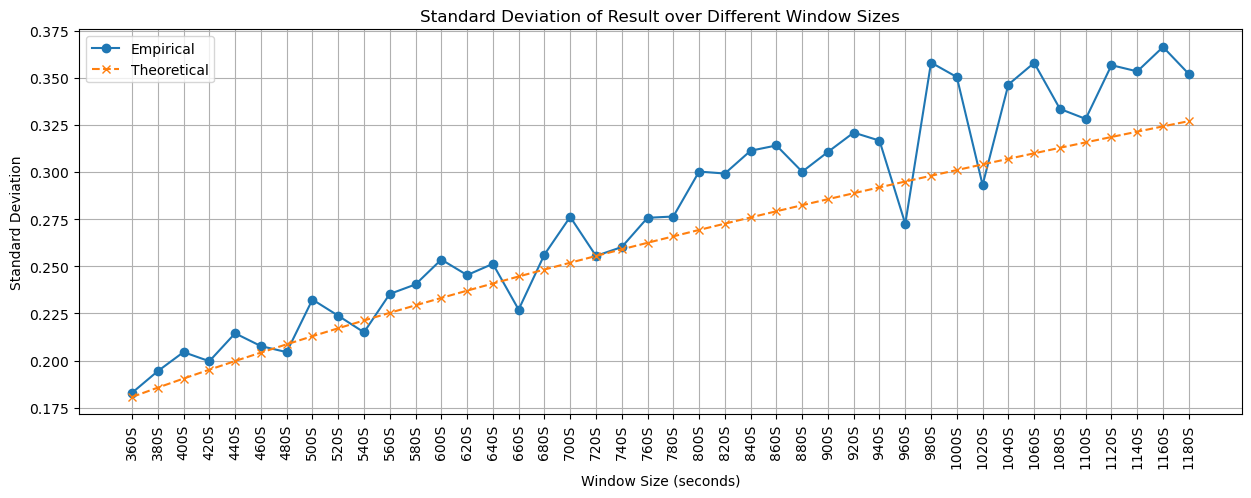